# Construct a custom Environment for Pair Trading

Some examples on the market
* [custom env example](https://colab.research.google.com/github/araffin/rl-tutorial-jnrr19/blob/sb3/5_custom_gym_env.ipynb#scrollTo=RqxatIwPOXe_)
* [StockTradingEnv by Adam King](https://github.com/notadamking/Stock-Trading-Environment)
* [FinRL](https://github.com/AI4Finance-Foundation/FinRL)

Target is to construct a custom Env for pair trading

This env restrict the behaviour of RL learner to pair trading only
The env enables the agent to freely bet on trading quantity.
Also, Technical Indicators from TA-lib is also provided to RL

## Import the Custom Trading Env

In [1]:
import os
import csv
import pickle
import pandas as pd
import quantstats as qs
import matplotlib.pyplot as plt
from tqdm import trange
from stable_baselines3 import PPO, A2C, DDPG, SAC, TD3

from params import *
from utils.read2df import read2df, unify_dfs
from utils.clearlogs import clear_logs
from utils.rlmetrics import get_return, get_metrics
from envs.env_rl_restrict_thres import RL_RestrictFreeAmt_TradeEnv

folder_path = f"result/rl-restrict-thres-freeamt"
os.makedirs(folder_path, exist_ok=True)

## Prepare Trading Data
Load data from `preliminaries.ipynb`

In [2]:
with open('result/cointncorr.pickle', 'rb') as pk:
    cointncorr = pickle.load(pk)

with open('result/gridsearch/best_res.pickle', 'rb') as pk:
    best_profit, best_params = pickle.load(pk)

dfs = read2df(symbols=cointncorr[0], freqs={cointncorr[1]: freqs[cointncorr[1]]}, marketType='spot')
tics, df = unify_dfs(dfs, symbols=cointncorr[0], period=best_params['period'], TI=True)

In [10]:
import talib
from talib.abstract import *
# Choose one indicator on each Indicator Groups

## Overlap Studies: BBANDS Bollinger Bands
## Momentum Indicators: ADX - Average Directional Movement Index
## Volume Indicators: AD Chaikin A/D Line
## Volatility Indicators: ATR Average True Range
## Cycle Indicators: HT_DCPERIOD Hilbert Transform - Dominant Cycle Period

df['upperband0'], df['middleband0'], df['lowerband0'] = BBANDS(df['close0'], timeperiod=best_params['period'])
df['upperband1'], df['middleband1'], df['lowerband1'] = BBANDS(df['close1'], timeperiod=best_params['period'])
df['adx0'] = ADX(df['high0'], df['low0'], df['close0'], timeperiod=best_params['period'])
df['adx1'] = ADX(df['high1'], df['low1'], df['close1'], timeperiod=best_params['period'])
df['ad0'] = AD(df['high0'], df['low0'], df['close0'], df['volume0'])
df['ad1'] = AD(df['high1'], df['low1'], df['close1'], df['volume1'])
df['atr0'] = ATR(df['high0'], df['low0'], df['close0'], timeperiod=best_params['period'])
df['atr1'] = ATR(df['high1'], df['low1'], df['close1'], timeperiod=best_params['period'])
df['ht_dcperiod0'] = HT_DCPERIOD(df['close0'])
df['ht_dcperiod1'] = HT_DCPERIOD(df['close1'])

df.dropna(inplace=True)

In [15]:
df.head()

,time,high0,low0,volume0,close0,itvl,datetime,high1,low1,volume1,...,middleband1,lowerband1,adx0,adx1,ad0,ad1,atr0,atr1,ht_dcperiod0,ht_dcperiod1
39,1672533599999,15410.22,15402.20,0.91172,0.000065,1m,2023-01-01 00:39:59.999,13661.40,13660.44,0.07082,...,0.000073,0.000073,16.330117,21.686687,-164131.448986,-21846.064160,15417.744567,13666.779168,25.685034,25.710022
40,1672533659999,15409.05,15403.39,0.15660,0.000065,1m,2023-01-01 00:40:59.999,13659.01,13658.96,0.01594,...,0.000073,0.000073,16.843377,22.167316,-164983.962782,-30555.032949,15417.309835,13666.390706,26.568471,26.596556
41,1672533719999,15407.42,15397.19,1.26157,0.000065,1m,2023-01-01 00:41:59.999,13656.01,13655.43,0.48026,...,0.000073,0.000073,17.757095,22.895158,-168782.806543,-53169.846922,15416.815340,13665.871667,27.316431,27.344156
42,1672533779999,15399.01,15397.27,0.20591,0.000065,1m,2023-01-01 00:42:59.999,13656.01,13656.01,0.00000,...,0.000073,0.000073,18.625127,23.586608,-172427.209984,-53169.846922,15415.925070,13665.378580,27.947131,27.970556
43,1672533839999,15400.23,15396.89,0.26236,0.000065,1m,2023-01-01 00:43:59.999,13656.01,13656.01,0.00000,...,0.000073,0.000073,19.282962,24.243485,-174846.351412,-53169.846922,15415.140313,13664.910147,28.476346,28.494015


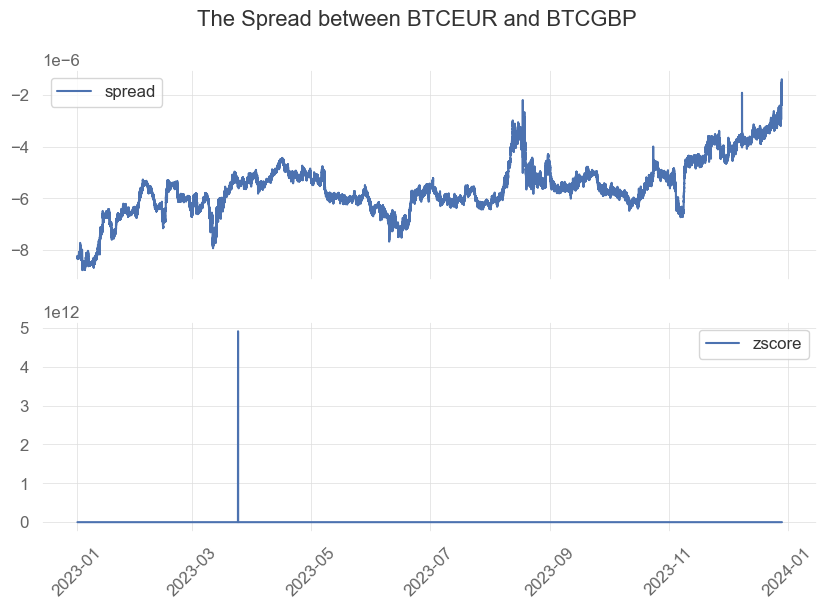

In [16]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

ax1.plot(df['datetime'], df['spread'], label='spread')
ax2.plot(df['datetime'], df['zscore'], label='zscore')

ax1.legend()
ax2.legend()
plt.suptitle(f'The Spread between {cointncorr[0][0]} and {cointncorr[0][1]}')

plt.xticks(rotation=45)
plt.show()

In [ ]:
train = df[(df['datetime'] >= datetime.strptime(start_date, date_format)) & (df['datetime'] < datetime.strptime(trade_date, date_format))]
test = df[(df['datetime'] >= datetime.strptime(trade_date, date_format)) & (df['datetime'] < datetime.strptime(end_date, date_format))]

max_train_len = int((len(train)-best_params['period'])*0.95)
print(f"The length of our training data: {len(train)}")

## Check with baselin3 `env_checker`

Check if the env meets the requirements of `stable_baseline3`

In [ ]:
from stable_baselines3.common.env_checker import check_env

env = RL_RestrictFreeAmt_TradeEnv(train)
check_env(env)

In [ ]:
test_env_expt = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(20):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    # test_env_expt.render()

test_env_expt.close()

Tensorboard

## Train the Model with Trading Env

In [ ]:
log_path = f"logs/restrict_thres_freeamt/"
clear_logs(log_path)

# Read more about tensorboard
# https://github.com/tensorflow/tensorboard/blob/master/README.md
# https://www.tensorflow.org/tensorboard/get_started

In [ ]:
'''PPO'''

model_ppo = PPO("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_ppo.learn(total_timesteps=max_train_len, progress_bar=False)
model_ppo.save(f"{folder_path}/ppo_pairtrading")

In [ ]:
'''A2C'''

model_a2c = A2C("MultiInputPolicy", env, verbose=0, gamma=1, tensorboard_log=log_path)
model_a2c.learn(total_timesteps=max_train_len, progress_bar=True)
model_a2c.save(f"{folder_path}/a2c_pairtrading")

In [ ]:
# '''
# DDPG
# '''

# model_ddpg = DDPG("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
# model_ddpg.learn(total_timesteps=max_train_len*0.9, progress_bar=True)
# model_ddpg.save(f"{folder_path}/ddpg_pairtrading")

In [ ]:
'''
SAC
'''

model_sac = SAC("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_sac.learn(total_timesteps=max_train_len, progress_bar=True)
model_sac.save(f"{folder_path}/sac_pairtrading")

In [ ]:
'''
TD3
'''

model_td3 = TD3("MultiInputPolicy", env, verbose=0, gamma=1, batch_size=256, tensorboard_log=log_path)
model_td3.learn(total_timesteps=max_train_len*0.95, progress_bar=True)
model_td3.save(f"{folder_path}/td3_pairtrading")

## Create the Custom Test Env

In [ ]:
test_env_ppo = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_ppo.csv", verbose=1)
test_env_a2c = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_a2c.csv", verbose=1)
test_env_ddpg = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_ddpg.csv", verbose=1)
test_env_sac = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_sac.csv", verbose=1)
test_env_td3 = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_td3.csv", verbose=1)
test_env_expt = RL_RestrictFreeAmt_TradeEnv(test, model=f"{folder_path}/networth_expt.csv", verbose=1)

In [ ]:
max_test_len = int(len(test) * 0.95)
print(f"The length of our test data: {max_test_len}")

## Test Env with Trained Model

In [ ]:
try:
    os.remove(f"{folder_path}/networth_ppo.csv")
except OSError:
    pass

obs, _ = test_env_ppo.reset()

for i in trange(max_test_len):
    action, _states = model_ppo.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_ppo.step(action)
    if i%int(max_test_len/10)==0:
        test_env_ppo.render()

test_env_ppo.close()

In [ ]:
try:
    os.remove(f"{folder_path}/networth_a2c.csv")
except OSError:
    pass

obs, _ = test_env_a2c.reset()

for i in trange(max_test_len):
    action, _states = model_a2c.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_a2c.step(action)
    if i%int(max_test_len/10)==0:
        test_env_a2c.render()

test_env_a2c.close()

In [ ]:
# try:
#     os.remove(f"{folder_path}/networth_ddpg.csv")
# except OSError:
#     pass

# obs, _ = test_env_ddpg.reset()

# for i in trange(max_test_len):
#     action, _states = model_ddpg.predict(obs)
#     obs, rewards, terminated, truncated, info = test_env_ddpg.step(action)
#     if i%int(max_test_len/10)==0:
#         test_env_ddpg.render()

# test_env_ddpg.close()

In [ ]:
try:
    os.remove(f"{folder_path}/networth_sac.csv")
except OSError:
    pass

obs, _ = test_env_sac.reset()

for i in trange(max_test_len):
    action, _states = model_sac.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_sac.step(action)
    if i%int(max_test_len/10)==0:
        test_env_sac.render()

test_env_sac.close()

In [ ]:
try:
    os.remove(f"{folder_path}/networth_td3.csv")
except OSError:
    pass

obs, _ = test_env_td3.reset()

for i in trange(max_test_len):
    action, _states = model_td3.predict(obs)
    obs, rewards, terminated, truncated, info = test_env_td3.step(action)
    if i%int(max_test_len/10)==0:
        test_env_td3.render()

test_env_td3.close()

## Also run randomly generated actions

In [ ]:
try:
    os.remove(f"{folder_path}/networth_expt.csv")
except OSError:
    pass

obs, _ = test_env_expt.reset()

for i in trange(max_test_len):
    obs, rewards, terminated, truncated, info = test_env_expt.step(action=env.action_space.sample())
    if i%int(max_test_len/10)==0:
        test_env_expt.render()

test_env_expt.close()

### Analyze with Quanstats

In [ ]:
os.remove(f"{folder_path}/networth_expt.csv") if os.path.exists(f"{folder_path}/networth_expt.csv") else None

csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]

best_res, best_model = None, None
for file_name in csv_files:
    file_path = os.path.join(folder_path, file_name)
    
    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Loop through the lines in the CSV file
        last_line = None
        for row in csv_reader:
            last_line = row  # Update last_line with the current row
    
    if best_res is None or float(best_res) < float(last_line[1]):
        best_res = last_line[1]
        best_model = file_name

    print(f"The ending capital of {file_name} is {last_line[0:2]}")

print(f"The best model is {best_model}")

In [ ]:
best_return = get_return(f'{folder_path}/{best_model}')
get_metrics(best_return)

In [ ]:
best_return

In [ ]:
fig, ax = plt.subplots()

ax.set_title("Profit and Loss")
ax.plot(best_return['returns'])

plt.show()

In [ ]:
qs.reports.full(best_return['returns'])